<a href="https://colab.research.google.com/github/lais-santiago/FIAP_TechChallenge2/blob/main/Tech_Challenge_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1) Importação de *bibliotecas*

In [898]:
#!pip install statsforecast

In [899]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


#2) Importação do Dataframe

Para este Tech Challenge será preciso realizar um modelo preditivo com dados da IBOVESPA (IBOV), para criar uma série temporal e prever diariamente o fechamento da base.

Para tanto foi feito download dos dados históricos de um ano através do site [investing](https://br.investing.com/indices/bovespa-historical-data), com periodicidade diária, de 27/07/2020 a 27/07/2024.

In [900]:
df_path = "https://raw.githubusercontent.com/lais-santiago/FIAP_TechChallenge2/main/Base%20de%20dados/Dados%20Histo%CC%81ricos%20-%20Ibovespa%202020%20a%202024.csv"

In [901]:
df = pd.read_csv(df_path, sep=",", thousands=".", parse_dates=[0])

<ipython-input-901-dc8e62f615b5>:1: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(df_path, sep=",", thousands=".", parse_dates=[0])


#3) Análise Exploratória dos Dados

Nessa visualização inicial é possível verificar que o Dataframe possui 997 linhas e 7 colunas.

Como o período selecionado é de quatro anos, mas existem somente 997 linhas no dataframe, podemos afirmar que nem todos os dias possuem valores.

Como se trata de bolsa de valores, há a hipótese de haverem menos linhas do que 1.460, pois as datas são de dias úteis e não corridos.

In [902]:
df

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2024-07-26,127492,125964,127700,125953,"8,27M","1,22%"
1,2024-07-25,125954,126423,126423,125626,"7,13M","-0,37%"
2,2024-07-24,126423,126596,126823,126218,"7,30M","-0,13%"
3,2024-07-23,126590,127860,127860,126530,"7,02M","-0,99%"
4,2024-07-22,127860,127616,128151,127456,"6,10M","0,19%"
...,...,...,...,...,...,...,...
992,2020-07-31,102912,105010,105462,102642,"12,93M","-2,00%"
993,2020-07-30,105009,105605,105607,103920,"9,59M","-0,56%"
994,2020-07-29,105605,104112,105704,104112,"9,24M","1,44%"
995,2020-07-28,104109,104477,104663,103592,"9,09M","-0,35%"


Com o comando head(15) é possível ver que realmente os dados do Dataframe são apenas de dias úteis.

In [903]:
df.head(15)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2024-07-26,127492,125964,127700,125953,"8,27M","1,22%"
1,2024-07-25,125954,126423,126423,125626,"7,13M","-0,37%"
2,2024-07-24,126423,126596,126823,126218,"7,30M","-0,13%"
3,2024-07-23,126590,127860,127860,126530,"7,02M","-0,99%"
4,2024-07-22,127860,127616,128151,127456,"6,10M","0,19%"
5,2024-07-19,127616,127652,128360,127413,"7,62M","-0,03%"
6,2024-07-18,127652,129450,129454,127523,"7,59M","-1,39%"
7,2024-07-17,129450,129112,129658,128741,"6,67M","0,26%"
8,2024-07-16,129110,129322,129521,128761,"6,82M","-0,16%"
9,2024-07-15,129321,128898,129485,128723,"5,83M","0,33%"


Ao checar as informações do dataframe é possível identificar que a coluna 'Data' foi corretamente importada como datetime e as colunas 'Vol.' e 'Var%' possuem formatos de objetos, o que não possibilita o uso de algumas ferramentas.

Mas como para solucionar o desafio será necessário o valor de fechamento, as únicas colunas necessárias serão 'Data' e 'Último', para analisarmos a progressão diária dos valores de fechamento da Ibovespa.

In [904]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997 entries, 0 to 996
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      997 non-null    datetime64[ns]
 1   Último    997 non-null    int64         
 2   Abertura  997 non-null    int64         
 3   Máxima    997 non-null    int64         
 4   Mínima    997 non-null    int64         
 5   Vol.      997 non-null    object        
 6   Var%      997 non-null    object        
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 54.6+ KB


Com o uso do isnull().sum() é possível afirmar que não há dados nulos em nenhuma das colunas que compõem esse Dataframe.

In [905]:
df.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        0
Var%        0
dtype: int64

Estatística descritiva dos dados contidos em todas as colunas.

In [906]:
df.describe()

,Data,Último,Abertura,Máxima,Mínima
count,997,997.000000,997.000000,997.000000,997.000000
mean,2022-07-28 07:07:31.354062336,114417.952859,114393.273821,115349.295888,113455.539619
min,2020-07-27 00:00:00,93580.000000,93586.000000,95340.000000,93387.000000
25%,2021-07-29 00:00:00,107431.000000,107387.000000,108489.000000,106296.000000
50%,2022-07-28 00:00:00,114178.000000,114169.000000,115063.000000,113036.000000
75%,2023-07-27 00:00:00,120859.000000,120817.000000,121772.000000,120084.000000
max,2024-07-26 00:00:00,134194.000000,134194.000000,134392.000000,133832.000000
std,NaN,9280.088865,9278.336692,9151.025920,9372.042789


Com o uso do duplicated().sum() é possível afirmar que não há linhas duplicadas no Dataframe.

In [907]:
df.duplicated().any().sum()

0

Também é possível afirmar que não há nenhum registro somente com a data duplicada.

Ou seja, no Dataframe para cada data há apenas um conjunto de informações.

In [908]:
df['Data'].duplicated().any().sum()

0

Visualização da evoluçao do valor de fechamento (coluna 'Último') ao longo dos dias, através de um gráfico de linha.

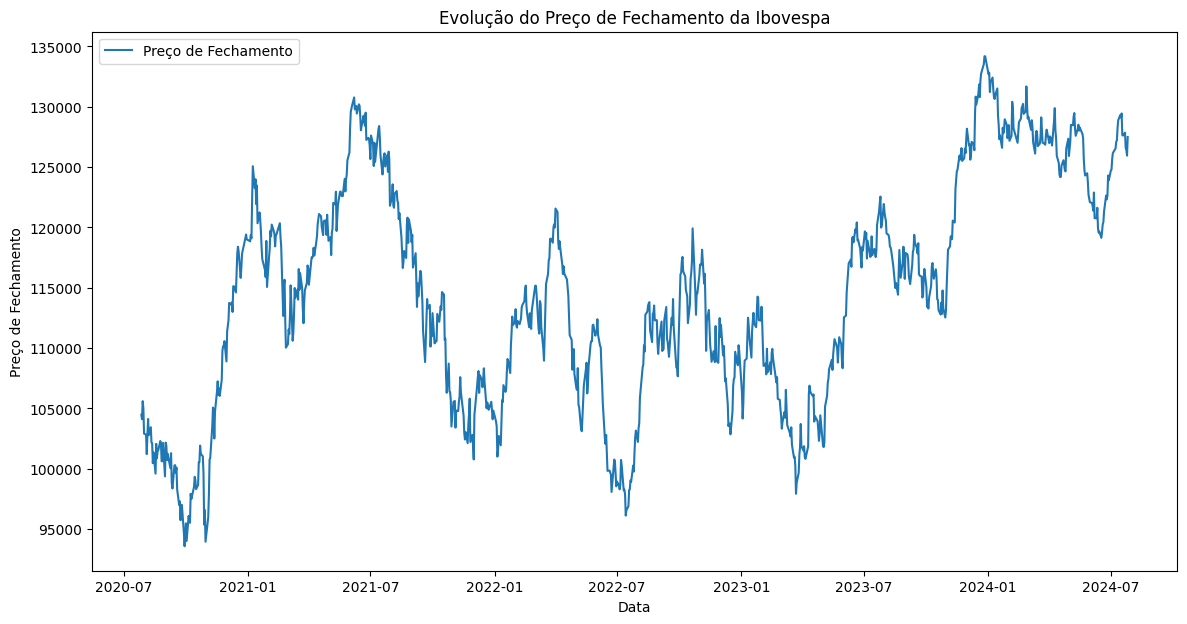

In [909]:
plt.figure(figsize=(14, 7))
plt.plot(df["Data"], df["Último"], label="Preço de Fechamento")
plt.title("Evolução do Preço de Fechamento da Ibovespa")
plt.xlabel("Data")
plt.ylabel("Preço de Fechamento")
plt.legend()
plt.show()

Decomposição da série temporal, onde extraímos as seguintes informações do período de 02/01/2024 até a data mais recente do dataframe 27/07/2024:

*   Trend - Nos mostra a tendência de direção da evolução dos dados (subida e descida)
*   Seasonal - Nos mostra a recorrência das oscilações dos valores ao longo do tempo, ou seja, sazonalidade
*   Resid - Nos mostra o residual, que não se trata de tendência nem a sazonalidade dos dados.



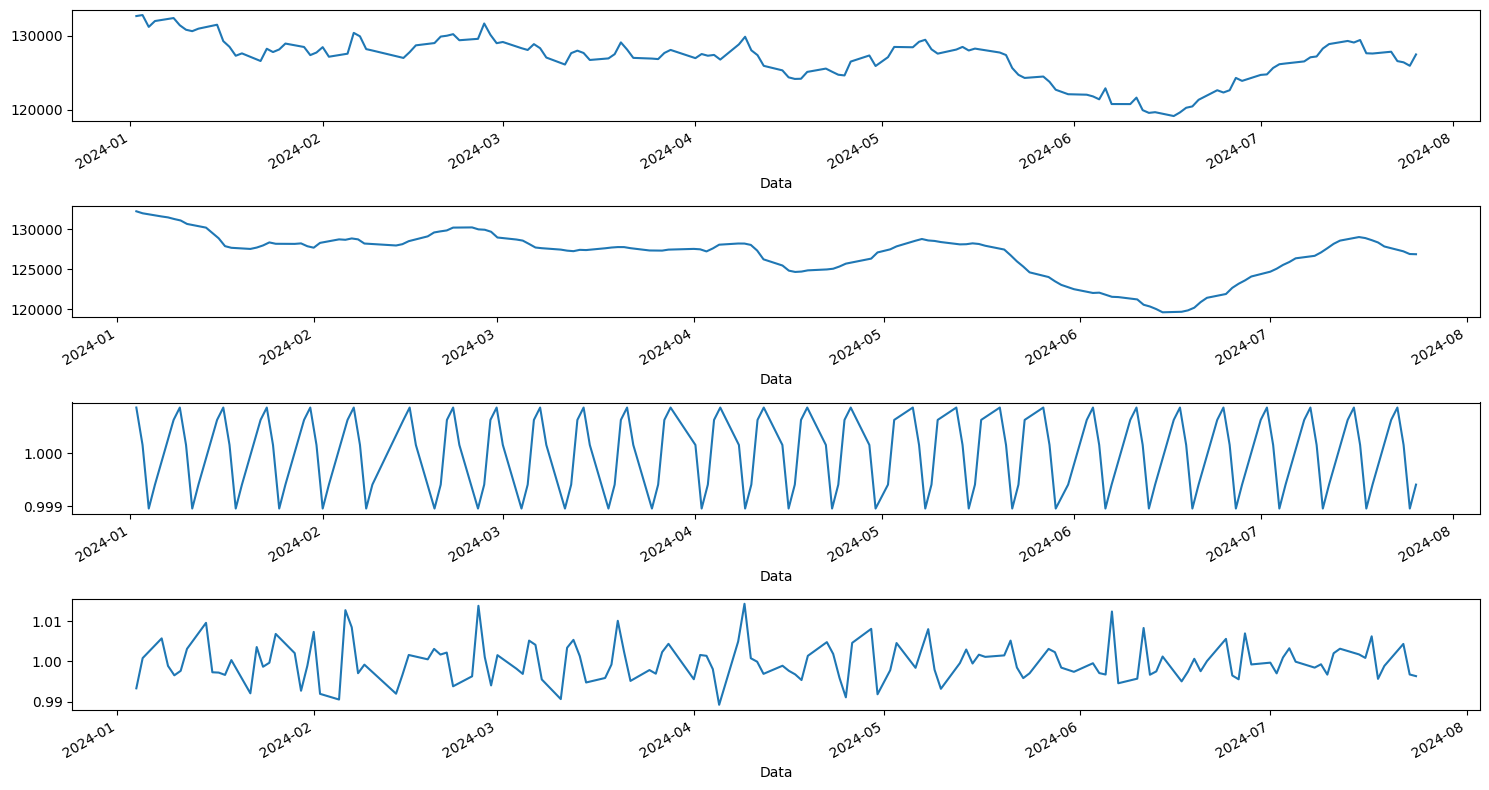

In [910]:
df_limpo = df.copy()
df_limpo = df_limpo.set_index('Data')
df_limpo.drop(columns=['Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'], inplace=True)
df_2024 = df_limpo.loc['2024-01-02':]

seasonplot = seasonal_decompose(df_2024, model='multiplicative', period=5) #decopondo a série temporal
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))
seasonplot.observed.plot(ax=ax1) #serie real
seasonplot.trend.plot(ax=ax2)    #tendencia
seasonplot.seasonal.plot(ax=ax3) #sazonalisade
seasonplot.resid.plot(ax=ax4)    #residuos
plt.tight_layout()

#4) Preparação do dataframe para a análise

Primeiramente precisamos reformatar o Dataframe em um formato mais adequado para análise de séries temporais, composto por uma coluna 'ds' que conterá as datas e uma coluna 'y' que conterá os valores de fechamento.

In [911]:
dados = df[['Data', 'Último']]
dados.rename(columns={'Data': 'ds', 'Último': 'y'}, inplace=True)

dados

<ipython-input-911-4d78d37a9ad6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados.rename(columns={'Data': 'ds', 'Último': 'y'}, inplace=True)


,ds,y
0,2024-07-26,127492
1,2024-07-25,125954
2,2024-07-24,126423
3,2024-07-23,126590
4,2024-07-22,127860
...,...,...
992,2020-07-31,102912
993,2020-07-30,105009
994,2020-07-29,105605
995,2020-07-28,104109


Como os dados contidos no Dataframe contemplam somente dias úteis e podem haver feriados, para não haver problemas na análise dos modelos, será necessário preencher os dias faltantes com os valores do dia anterior.

Estou mantendo a frequencia das datas em dias úteis (freq = 'B')

Após esse tratamento, o dataframe aumentou o número de linhas de 997 linhas para 1045 linhas.

In [912]:
# Criando um intervalo completo de datas
data_ini = dados['ds'].min()
data_fim = dados['ds'].max()
datas = pd.date_range(start=data_ini, end=data_fim, freq='B')

# Reindexar o DataFrame original para incluir todos os dias úteis
dados = dados.set_index('ds').reindex(datas).rename_axis('ds').reset_index()

# Preencher valores faltantes com o último valor conhecido
dados['y'] = dados['y'].ffill()

dados

,ds,y
0,2020-07-27,104477.0
1,2020-07-28,104109.0
2,2020-07-29,105605.0
3,2020-07-30,105009.0
4,2020-07-31,102912.0
...,...,...
1040,2024-07-22,127860.0
1041,2024-07-23,126590.0
1042,2024-07-24,126423.0
1043,2024-07-25,125954.0


Será necessário adicionar a coluna unique_id que conterá o ID, que é único na tabela toda: "IBOV", representando Ibovespa.

In [913]:
dados['unique_id'] = 'IBOV'

Última checagem para confirmar que continuam não existindo dados nulos no Dataframe.

In [914]:
dados.isnull().sum()

ds           0
y            0
unique_id    0
dtype: int64

#5) Criação de funções auxiliares para a validação dos modelos

* **MAE** (Mean Absolute Error) é uma métrica comumente utilizada para avaliar a precisão de modelos de previsão ou de regressão. Ela quantifica a média das diferenças absolutas entre os valores previstos por um modelo e os valores observados ou reais. O MAE calcula a média das diferenças absolutas entre cada valor previsto e seu valor real correspondente. Isso significa que o MAE não considera a direção dos erros (se são positivos ou negativos), apenas a magnitude. Valores menores de MAE indicam uma melhor precisão do modelo, pois significam que as previsões estão mais próximas dos valores reais.

* **MSE** (Mean Squared Error) é uma métrica utilizada para avaliar a precisão de modelos de previsão ou de regressão, calculando a média dos quadrados das diferenças entre os valores previstos por um modelo e os valores observados ou reais. O MSE é uma métrica que penaliza erros maiores de forma quadrática, o que significa que erros maiores têm um impacto maior na métrica final do que erros menores. Isso pode ser desejável em alguns casos onde é importante destacar erros significativos.

* **MAPE** (Mean Absolute Percentage Error) é uma métrica usada para avaliar a precisão de modelos de previsão ou de séries temporais, especialmente quando é importante entender o erro percentual médio das previsões em relação aos valores reais. O MAPE calcula a média das diferenças percentuais absolutas entre os valores previstos e os valores reais. Essa métrica expressa o erro médio em termos percentuais, o que facilita a interpretação e a comparação entre diferentes modelos ou séries temporais.

* **WMAPE** (Weighted Mean Absolute Percentage Error) é uma métrica utilizada para avaliar a precisão de modelos de previsão ou de séries temporais, especialmente quando os dados têm diferentes escalas ou quando é importante penalizar erros maiores de forma mais significativa. O WMAPE é calculado como a média ponderada dos erros absolutos percentuais (APEs) para todos os períodos, expresso como um percentual.

In [915]:
def calculo_metricas(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    wmape = np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()
    return mae, mse, mape, wmape

In [916]:
def exibir_metricas(metrics):
    mae, mse, mape, wmape = metrics
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"MAPE: {mape:.2%}")
    print(f"WMAPE: {wmape:.2%}")

#6) Separação dos dados de treino de teste

Para separar os dados de treino de teste consideramos o período de datas do Dataframe.

Para o treino serão utilizadas todas as datas contidas no dataframe de 27/07/2023 a 14/05/2024.

Para o teste serão consideradas as datas após o período de treino, ou seja, de 15/05/2024 a 27/07/2024, totalizando 53 dias úteis. Desta forma ficam então separados aproximadamente 80% da base para treino e 20% para teste.

In [917]:
treino = dados.loc[(dados['ds'] >= '2023-07-27') &(dados['ds'] < '2024-05-15')]
valid = dados.loc[(dados['ds'] >= '2024-05-15') & (dados['ds'] <= '2024-07-27')]

h = valid['ds'].nunique()
print('tamanho base teste: ', h)

h_t = treino['ds'].nunique()
print('tamanho base treino: ', h_t)

tamanho base teste:  53
tamanho base treino:  209


#7) Modelagem e predição dos dados

##7.1) Modelo de Média Móvel

In [918]:
forecast_ma = dados.copy()
forecast_ma['MA_window_15'] = dados['y'].rolling(15).mean().shift()
forecast_ma['MA_window_20'] = dados['y'].rolling(20).mean().shift()

forecast_ma.head(30)

,ds,y,unique_id,MA_window_15,MA_window_20
0,2020-07-27,104477.0,IBOV,NaN,NaN
1,2020-07-28,104109.0,IBOV,NaN,NaN
2,2020-07-29,105605.0,IBOV,NaN,NaN
3,2020-07-30,105009.0,IBOV,NaN,NaN
4,2020-07-31,102912.0,IBOV,NaN,NaN
5,2020-08-03,102830.0,IBOV,NaN,NaN
6,2020-08-04,101216.0,IBOV,NaN,NaN
7,2020-08-05,102802.0,IBOV,NaN,NaN
8,2020-08-06,104126.0,IBOV,NaN,NaN
9,2020-08-07,102776.0,IBOV,NaN,NaN


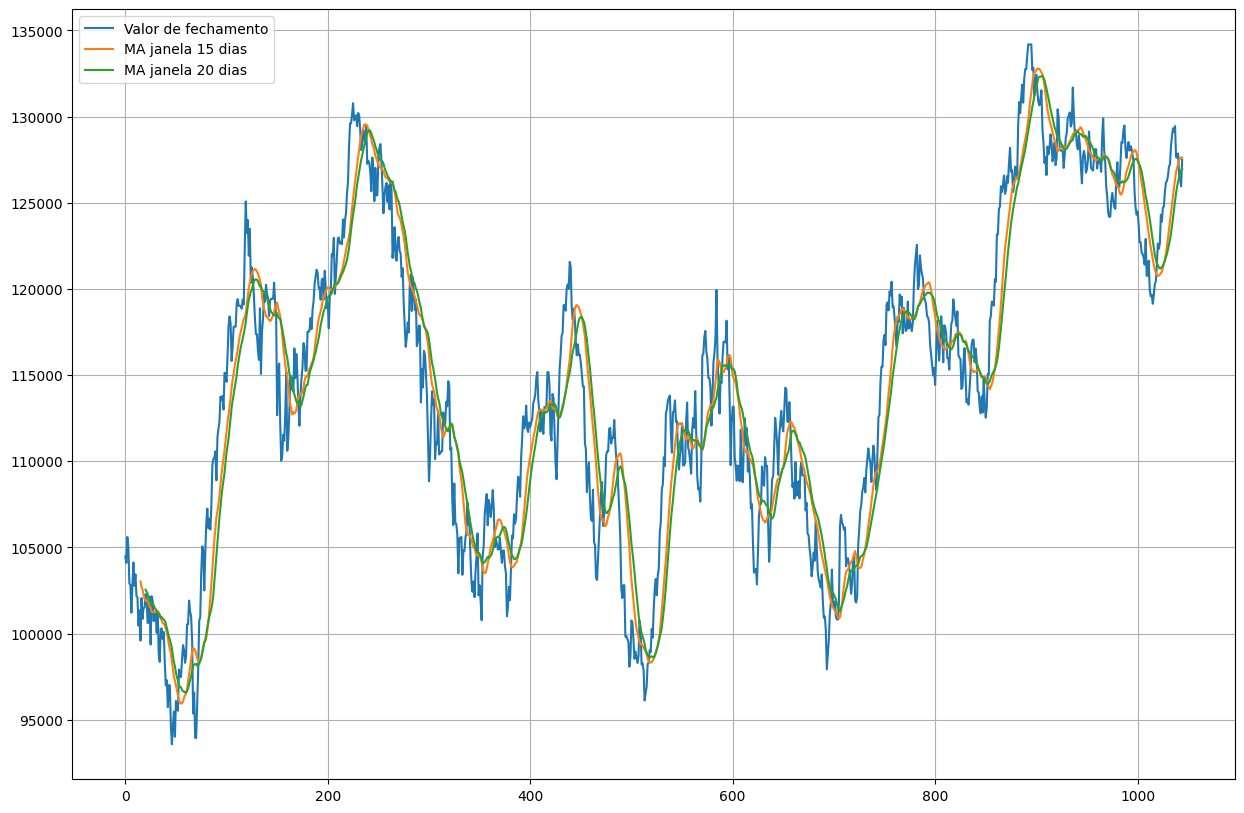

Avaliação média móvel com janela de 15 dias
MAE: 2419.89
MSE: 8901045.35
MAPE: 214.02%
WMAPE: 2.11%

Avaliação média móvel com janela de 20 dias
MAE: 2764.05
MSE: 11602115.83
MAPE: 244.14%
WMAPE: 2.41%


In [919]:
plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(forecast_ma['y'], label='Valor de fechamento')
plt.plot(forecast_ma['MA_window_15'], label='MA janela 15 dias')
plt.plot(forecast_ma['MA_window_20'], label='MA janela 20 dias')
plt.legend(loc=2)
plt.show()

forecast_ma = forecast_ma.dropna()

print('Avaliação média móvel com janela de 15 dias')
metrics_ma15 = calculo_metricas(forecast_ma['y'].values, forecast_ma['MA_window_15'].values)
exibir_metricas(metrics_ma15)

print('\nAvaliação média móvel com janela de 20 dias')
metrics_ma20 = calculo_metricas(forecast_ma['y'].values, forecast_ma['MA_window_20'].values)
exibir_metricas(metrics_ma20)

###7.2) Modelo SeasonalNaive

MAE: 3675.17
MSE: 17421092.42
MAPE: 297.66%
WMAPE: 2.95%


/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


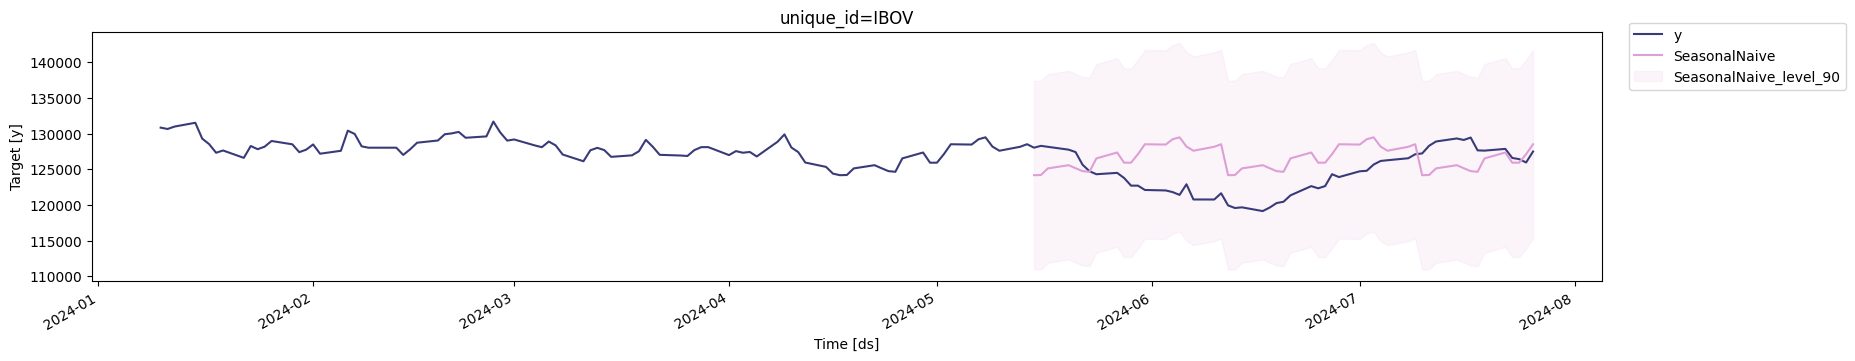

In [920]:
#Fazendo uma predição baseado no SeasonalNaive
model_sn = StatsForecast(models=[SeasonalNaive(season_length=20)], freq='B', n_jobs=-1)
model_sn.fit(treino)

forecast_sn = model_sn.predict(h=h, level=[90])
forecast_sn = forecast_sn.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

metrics_sn = calculo_metricas(forecast_sn['y'].values, forecast_sn['SeasonalNaive'].values)
exibir_metricas(metrics_sn)

model_sn.plot(treino, forecast_sn, level=[90], unique_ids=['IBOV'],engine ='matplotlib', max_insample_length=90)

###7.3) Modelo SeasonalWindowAverage

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


MAE: 3421.08
MSE: 16806340.59
MAPE: 278.62%
WMAPE: 2.75%


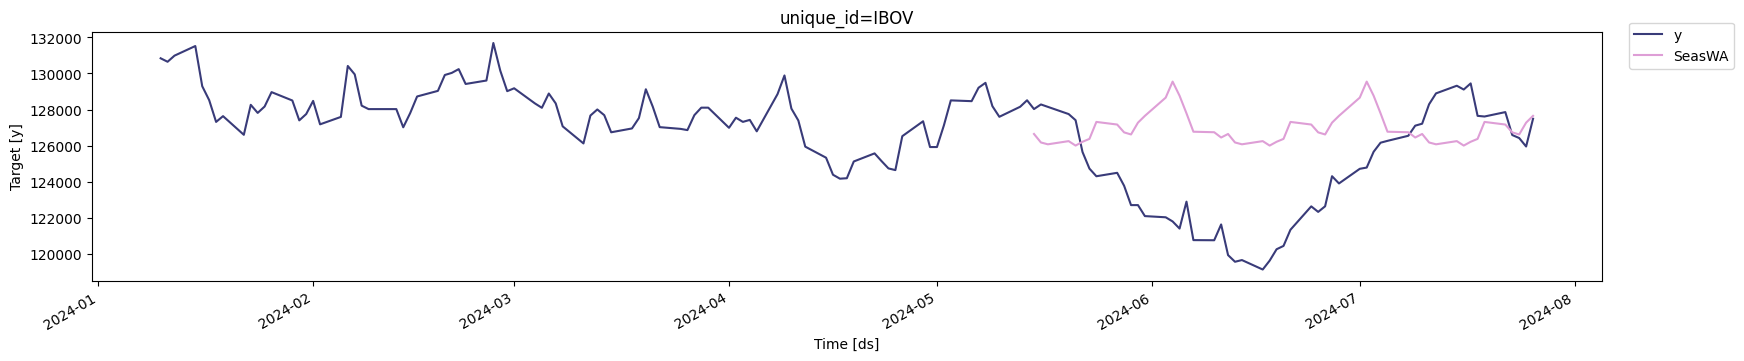

In [921]:
model_sm = StatsForecast(models=[SeasonalWindowAverage(season_length=20, window_size=2)], freq='B', n_jobs=-1)
model_sm.fit(treino)

forecast_sm = model_sm.predict(h=h)
forecast_sm = forecast_sm.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

metrics_sm = calculo_metricas(forecast_sm['y'].values, forecast_sm['SeasWA'].values)
exibir_metricas(metrics_sm)

model_sm.plot(treino, forecast_sm, unique_ids=['IBOV'],engine ='matplotlib', max_insample_length=90)

###7.4) Modelo AutoARIMA

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


MAE: 4082.89
MSE: 25103699.57
MAPE: 333.74%
WMAPE: 3.28%


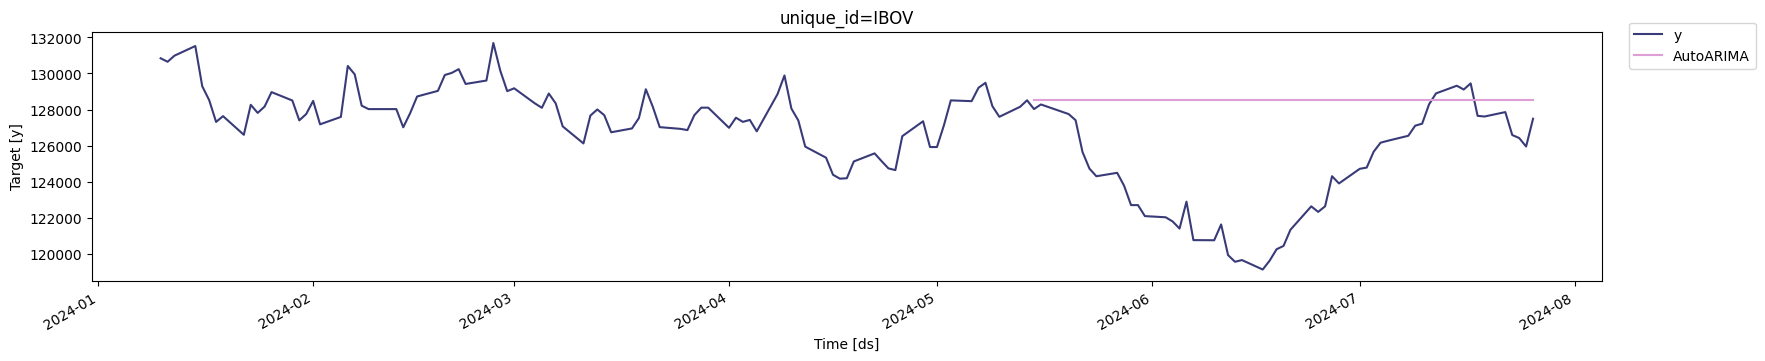

In [922]:
model_a = StatsForecast(models=[AutoARIMA(season_length=20)], freq='B', n_jobs=-1)
model_a.fit(treino)

forecast_a = model_a.predict(h=h, level=[90])
forecast_a = forecast_a.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

metrics_a = calculo_metricas(forecast_a['y'].values, forecast_a['AutoARIMA'].values)
exibir_metricas(metrics_a)

model_a.plot(treino, forecast_a, unique_ids=['IBOV'],engine ='matplotlib', max_insample_length=90)

### 7.5) Modelo ARIMA

####7.5.1) Analisando a correlação dos dados

In [923]:
# Limpando o dataset para testar o modelo ARIMA
df_arima = dados.copy()
df_arima = df_arima.set_index('ds')
df_arima.drop(columns=['unique_id'], inplace=True)
df_arima

,y
ds,
2020-07-27,104477.0
2020-07-28,104109.0
2020-07-29,105605.0
2020-07-30,105009.0
2020-07-31,102912.0
...,...
2024-07-22,127860.0
2024-07-23,126590.0
2024-07-24,126423.0


Autocorrelação e Autocorrelação parcial:
* ACF (autocorrelação) temos a correlação direta e indireta.
* PACF (autocorrelação parcial): apenas a correlação direta.

A ACF é uma ferramenta valiosa para entender padrões de dependência temporal nos dados.

O intervalo de confiança por padrão é 95%, mostrado como essa marca em azul. Observações que estão para fora da marca são consideradas estatisticamente correlacionadas.

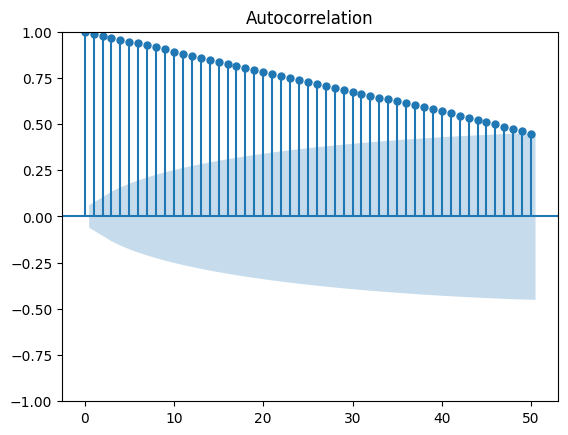

In [924]:
sm.graphics.tsa.plot_acf(df_arima, lags=50)
plt.show()

Fazendo a análise de correlação parcial direta, os lags não contribuem significativamente para a estrutura da autocorrelação parcial após considerar os efeitos dos lags intermediários (veja os lags na área em azul).

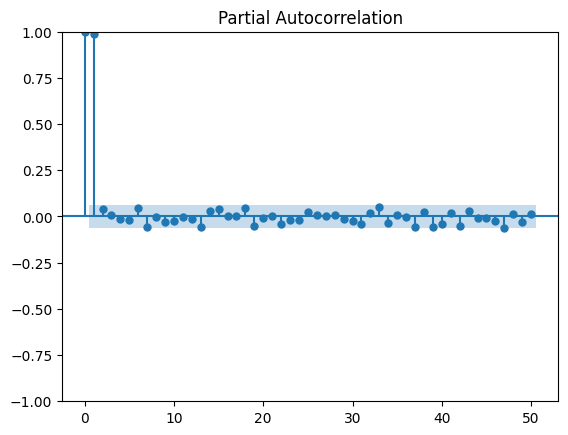

In [925]:
sm.graphics.tsa.plot_pacf(df_arima, lags=50)
plt.show()

####7.5.2) Analisando a média móvel com o desvio padrão

In [926]:
rolmean = df_arima.rolling(window=12).mean() #média móvel em 12 meses (dando a média móvel no nível anual).
rolstd = df_arima.rolling(window=12).std()   #Desvio padrão em 12 meses
print(rolmean,rolstd)

                        y
ds                       
2020-07-27            NaN
2020-07-28            NaN
2020-07-29            NaN
2020-07-30            NaN
2020-07-31            NaN
...                   ...
2024-07-22  127945.083333
2024-07-23  127972.000000
2024-07-24  127961.583333
2024-07-25  127865.416667
2024-07-26  127888.250000

[1045 rows x 1 columns]                       y
ds                     
2020-07-27          NaN
2020-07-28          NaN
2020-07-29          NaN
2020-07-30          NaN
2020-07-31          NaN
...                 ...
2024-07-22  1076.249249
2024-07-23  1033.662069
2024-07-24  1049.820457
2024-07-25  1179.913823
2024-07-26  1168.845516

[1045 rows x 1 columns]


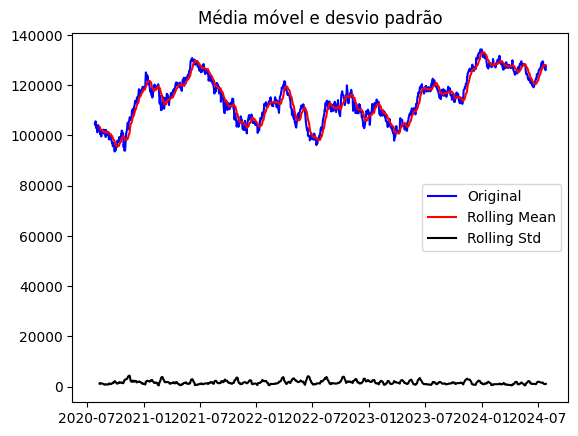

In [927]:
#Plotando a média móvel
orig = plt.plot(df_arima, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Média móvel e desvio padrão')
plt.show(block=False)

####7.5.3) Teste do Dickey-Fuller

**Estatística ADF:**

- H0 (Hipótese Nula): A série temporal não é estacionária.

- H1 (Hipótese Alternativa): A série temporal é estacionária.


**Interpretação:** Se a estatística ADF for menor que os valores críticos, podemos rejeitar a hipótese nula e considerar a série temporal estacionária. Quanto mais negativa a estatística, mais forte é a evidência contra a hipótese nula.

**Valor p (p-value):**

**Interpretação:** Um valor p menor que um determinado nível de significância (**por exemplo, 0.05**) fornece evidência contra a hipótese nula, sugerindo que a série temporal é estacionária.


Com base nestes indicadores podemos concluir que a série não é estacionária.

In [928]:
# Teste de estacionariedade (ADF Test)
adf_result = adfuller(df_arima['y'])
print('Teste Estatístico:', adf_result[0])
print('Valor-p:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

Teste Estatístico: -2.2054916690050073
Valor-p: 0.20425833900409784
Valores Críticos:
   1%: -3.43662916802936
   5%: -2.864312406409634
   10%: -2.5682461404339336


####7.5.4) Transformando a série em estacionária

####**1º teste**: subtrair os dados transformados pelo log pela média móvel.

**Objetivo**: Estabilizar a variância em uma série temporal, especialmente quando a amplitude dos dados varia ao longo do tempo.

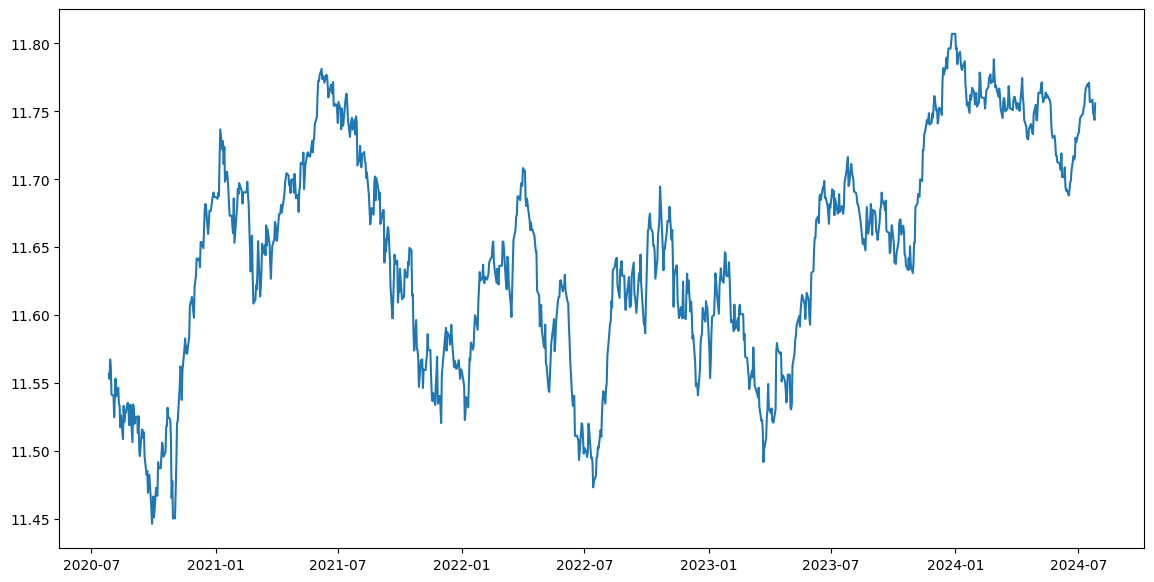

In [946]:
indexedDataset_logScale = np.log(df_arima) #Transformação logarítma
plt.figure(figsize=(14, 7))
plt.plot(indexedDataset_logScale)

Calculando a média móvel

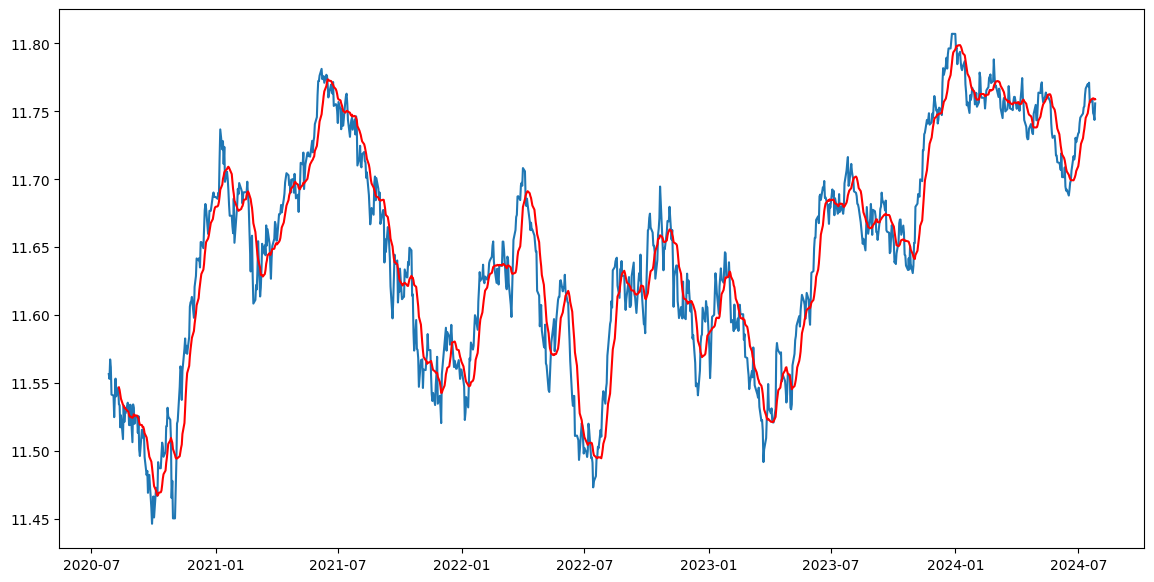

In [947]:
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.figure(figsize=(14, 7))
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

Subtraindo a média móvel dos dados transformados pelo log para remover o componente de tendência de ambos.

In [931]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

,y
ds,
2020-07-27,NaN
2020-07-28,NaN
2020-07-29,NaN
2020-07-30,NaN
2020-07-31,NaN
2020-08-03,NaN
2020-08-04,NaN
2020-08-05,NaN
2020-08-06,NaN


Removendo os valores nulos

In [932]:
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,y
ds,
2020-08-11,-0.012409
2020-08-12,-0.011054
2020-08-13,-0.024441
2020-08-14,-0.012176
2020-08-17,-0.025263
2020-08-18,-0.000076
2020-08-19,-0.010395
2020-08-20,-0.004533
2020-08-21,-0.002966


Testando a estacionaridade com os novos valores

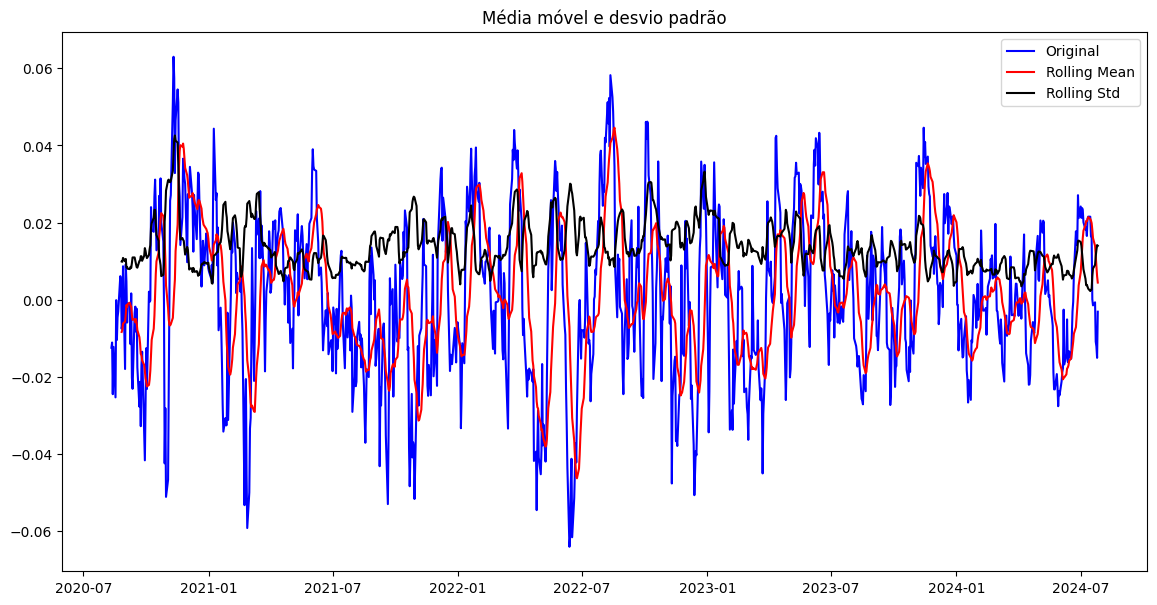

In [950]:
rolmean_2 = datasetLogScaleMinusMovingAverage.rolling(window=12).mean()
rolstd_2 = datasetLogScaleMinusMovingAverage.rolling(window=12).std()

plt.figure(figsize=(14, 7))

orig = plt.plot(datasetLogScaleMinusMovingAverage, color='blue', label='Original')
mean = plt.plot(rolmean_2, color='red', label='Rolling Mean')
std = plt.plot(rolstd_2, color='black', label='Rolling Std')

plt.legend(loc='best')
plt.title('Média móvel e desvio padrão')
plt.show(block=False)

Agora depois da transformação a série se torna estacionária.

In [934]:
# Teste de estacionariedade (ADF Test)
adf_result = adfuller(datasetLogScaleMinusMovingAverage['y'])
print('Teste Estatístico:', adf_result[0])
print('Valor-p:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

Teste Estatístico: -7.548465039070529
Valor-p: 3.2360699114636933e-11
Valores Críticos:
   1%: -3.4367709764382024
   5%: -2.8643749513463637
   10%: -2.568279452717228


#### **2º teste** : Decaimento exponencial.

**Objetivo:** Remover a tendência de uma série temporal. A ideia básica é aplicar uma média exponencial ponderada aos dados, atribuindo mais peso às observações mais recentes e menos peso às observações mais antigas.

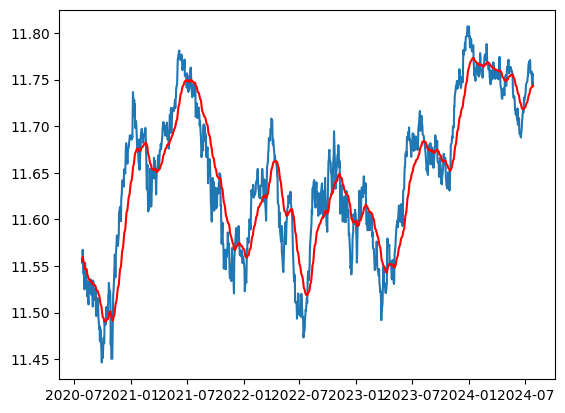

In [935]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

Subtraindo o dataset em escala logarítma pelo decaimento exponencial

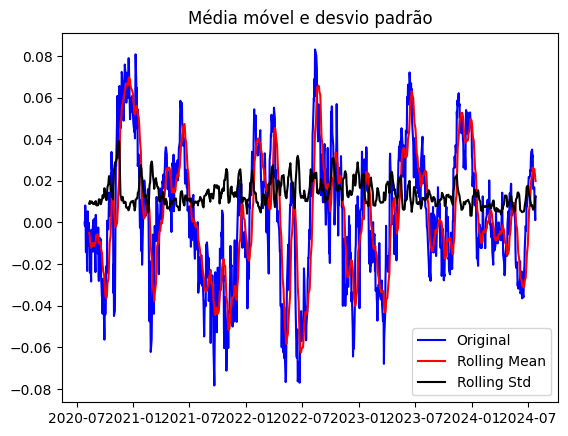

In [936]:
datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage

rolmean_3 = datasetLogScaleMinusExponentialMovingAverage.rolling(window=12).mean()
rolstd_3 = datasetLogScaleMinusExponentialMovingAverage.rolling(window=12).std()

orig = plt.plot(datasetLogScaleMinusExponentialMovingAverage, color='blue', label='Original')
mean = plt.plot(rolmean_3, color='red', label='Rolling Mean')
std = plt.plot(rolstd_3, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Média móvel e desvio padrão')
plt.show(block=False)

In [937]:
# Teste de estacionariedade (ADF Test)
adf_result = adfuller(datasetLogScaleMinusExponentialMovingAverage['y'])
print('Teste Estatístico:', adf_result[0])
print('Valor-p:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

Teste Estatístico: -5.797073373118059
Valor-p: 4.724685623663093e-07
Valores Críticos:
   1%: -3.43662916802936
   5%: -2.864312406409634
   10%: -2.5682461404339336


####**3º teste :** Diferenciação

**Objetivo:** Remover a tendência e tornar a série mais estacionária.

In [938]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift() #diferença entre o valor anterior e o atual

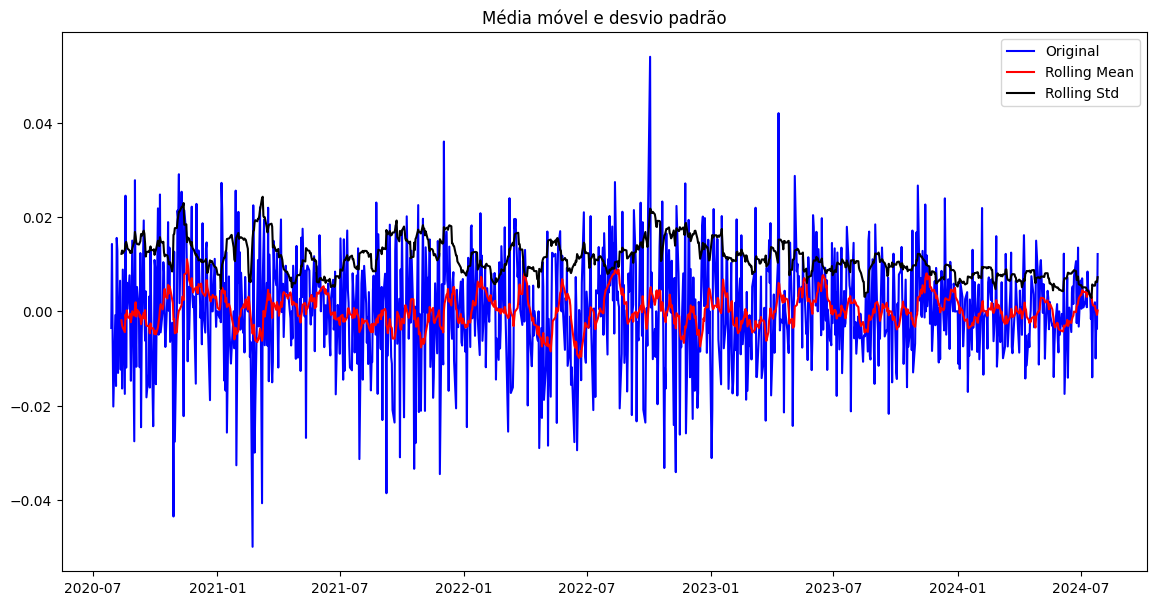

In [951]:
rolmean_4 = datasetLogDiffShifting.rolling(window=12).mean()
rolstd_4 = datasetLogDiffShifting.rolling(window=12).std()

plt.figure(figsize=(14, 7))
orig = plt.plot(datasetLogDiffShifting, color='blue', label='Original')
mean = plt.plot(rolmean_4, color='red', label='Rolling Mean')
std = plt.plot(rolstd_4, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Média móvel e desvio padrão')
plt.show(block=False)

In [940]:
# Teste de estacionariedade (ADF Test)
datasetLogDiffShifting.dropna(inplace=True)
adf_result = adfuller(datasetLogDiffShifting['y'])
print('Teste Estatístico:', adf_result[0])
print('Valor-p:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

Teste Estatístico: -33.59562543456795
Valor-p: 0.0
Valores Críticos:
   1%: -3.436635203238866
   5%: -2.8643150683130307
   10%: -2.568247558190521


####7.5.5) Descobrindo os valores de p e q pelo Teste de Correlação Parcial

A partir do gráfico ACF, vemos que a curva toca a linha y=0,0 em x=1 (Q = 1);

Do gráfico PACF, vemos que a curva toca a linha y=0,0 em x=1 (P = 1).

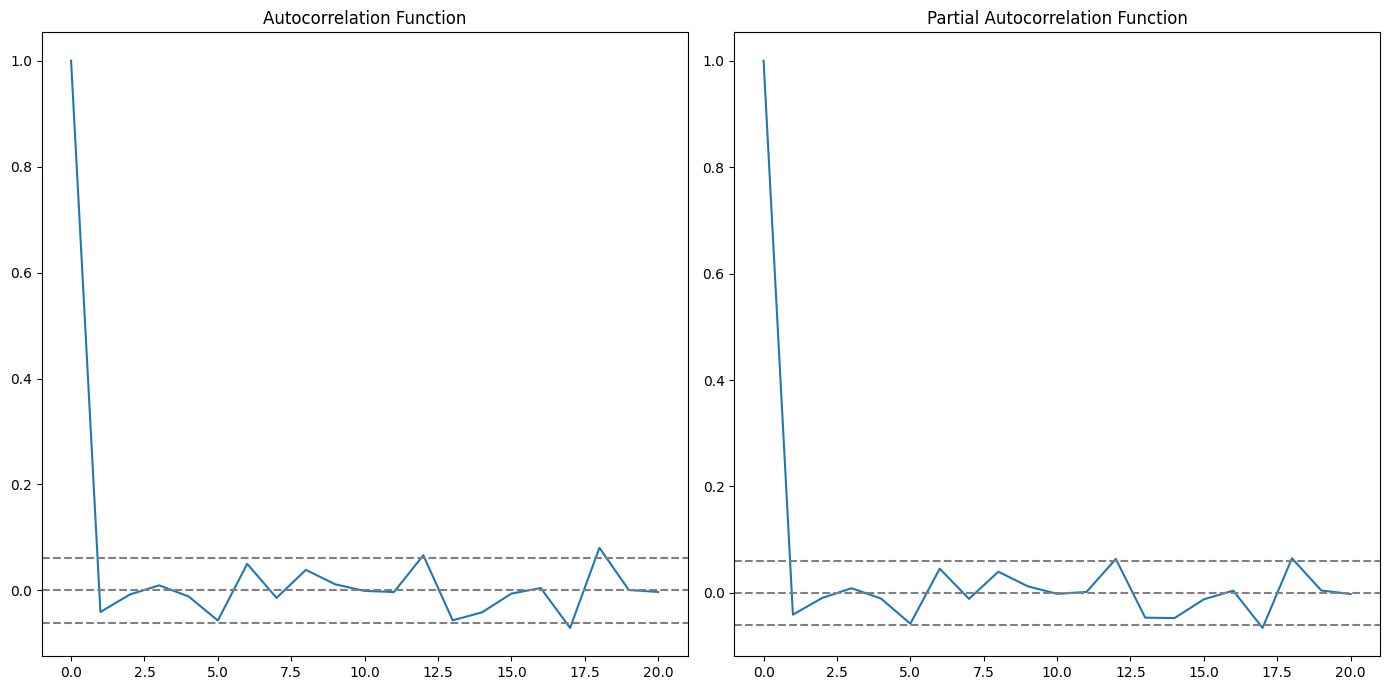

In [952]:
#ACF & PACF plots

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

plt.figure(figsize=(14, 7))

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()

####7.5.6) Aplicando o Modelo ARIMA

Valores RSS (Soma dos Quadrados dos Resíduos) mais baixos indicam um modelo melhor.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Plotting AR model


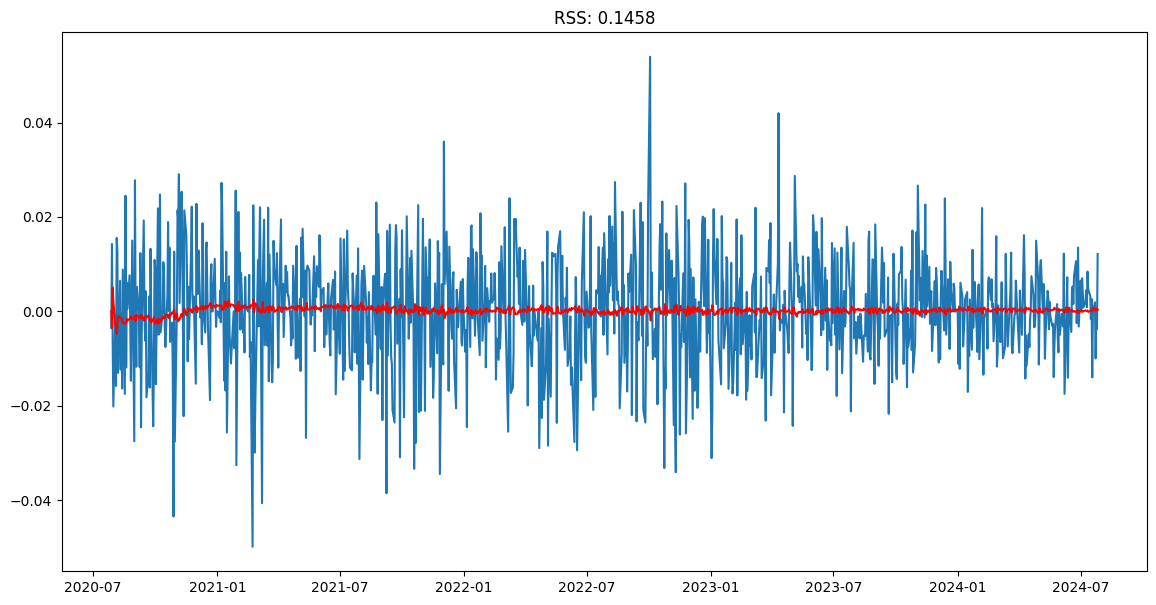

In [953]:
model = ARIMA(datasetLogDiffShifting, order=(1,1,1))#(p,d,q)
results_AR = model.fit()
plt.figure(figsize=(14, 7))
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['y'])**2))
print('Plotting AR model')

Usando o cálculo de métricas para validar o modelo.

In [943]:
results_AR.fittedvalues

ds
2020-07-28    0.000000
2020-07-29   -0.003529
2020-07-30    0.004866
2020-07-31    0.002523
2020-08-03   -0.003384
                ...   
2024-07-22   -0.000233
2024-07-23    0.000546
2024-07-24    0.000191
2024-07-25    0.000423
2024-07-26    0.000121
Length: 1044, dtype: float64

Validando pelo MAPE o resultado obtido com o modelo ARIMA, temos um valor muito alto, o que caracteriza como um modelo que tem valores muito distantes dos valores originais.

In [944]:
# Obtendo as previsões
predictions = results_AR.fittedvalues

# Ajuste os índices para garantir correspondência
predictions.index = datasetLogDiffShifting.index

# Inverta a diferenciação
# (indexedDataset_logScale['Close'].iloc[0]) para inverter a diferenciação.
# np.cumsum(predictions) é usado para calcular a soma cumulativa das previsões.
predicted_values = indexedDataset_logScale['y'].iloc[0] + np.cumsum(predictions)

# Calcule o MAPE
mape = mean_absolute_error(datasetLogDiffShifting['y'], predicted_values) * 100

print(f"MAPE: {mape:.2f}%")

MAPE: 1161.68%


##7.6) Modelo Prophet

Separando dados de treino e de teste

In [968]:
train_data = dados.sample(frac=0.8, random_state=0)
test_data = dados.drop(train_data.index)
print(f'training data size : {train_data.shape}')
print(f'testing data size : {test_data.shape}')

training data size : (836, 3)
testing data size : (209, 3)


DEBUG:cmdstanpy:input tempfile: /tmp/tmp5i2bv3qw/a8kqwqww.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5i2bv3qw/jae6axf2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19782', 'data', 'file=/tmp/tmp5i2bv3qw/a8kqwqww.json', 'init=/tmp/tmp5i2bv3qw/jae6axf2.json', 'output', 'file=/tmp/tmp5i2bv3qw/prophet_modeluo4l6ttb/prophet_model-20240728210717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:07:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:07:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 3101.75
MSE: 14316677.90
MAPE: 253.16%
WMAPE: 2.49%


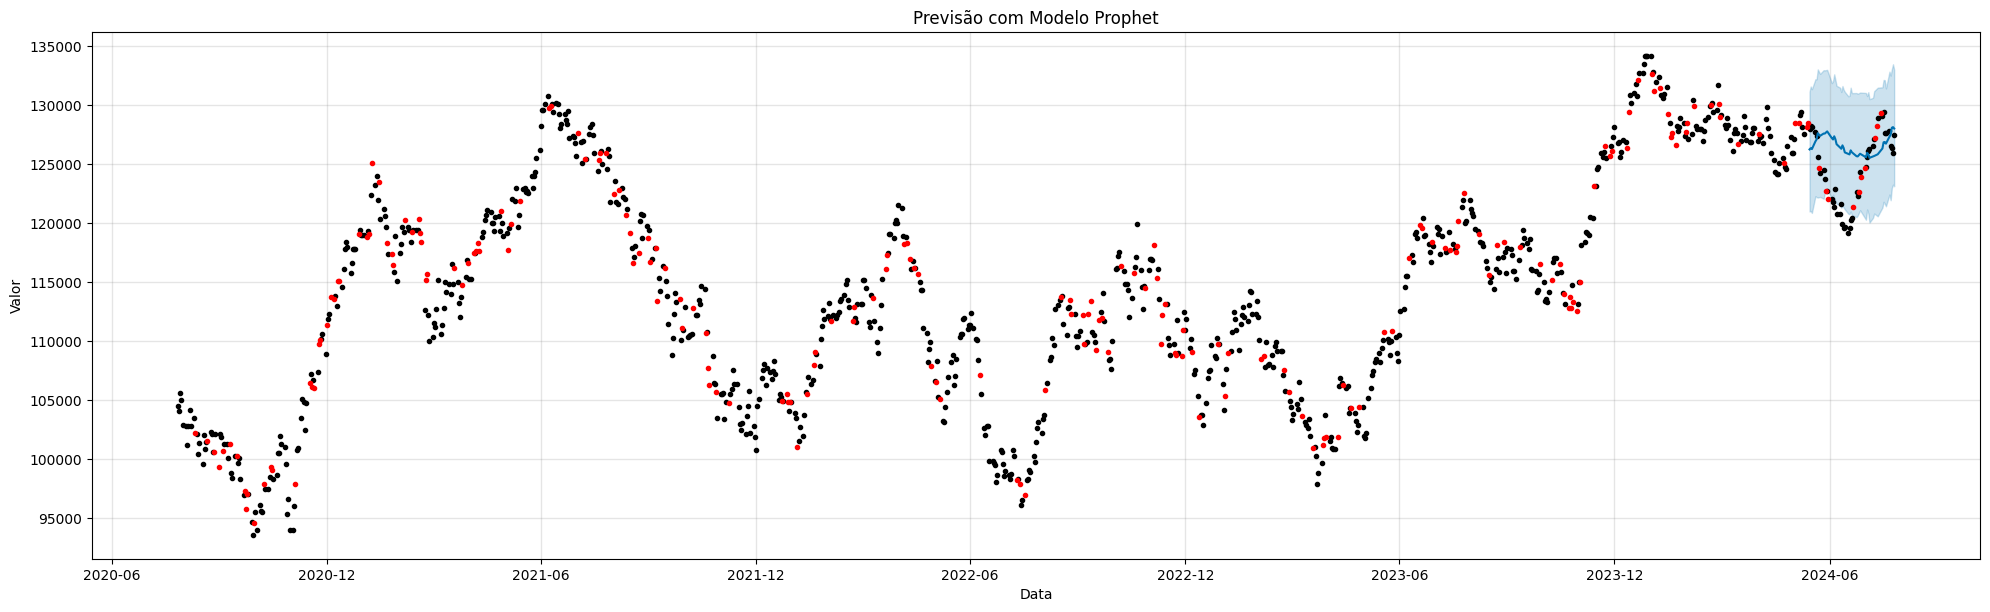

In [969]:
# Criar uma instância do modelo Prophet
modelp = Prophet(daily_seasonality=True)

# Ajustar o modelo aos dados
modelp.fit(train_data)


# Criar um dataframe para as datas futuras que queremos prever
future_dates = modelp.make_future_dataframe(periods=h, freq='B')

# Fazer previsões
forecast_p = modelp.predict(future_dates)
forecast_p = forecast_p.merge(valid,on=['ds'],how='inner')

metrics_p = calculo_metricas(forecast_p['y'].values, forecast_p['yhat'].values)
exibir_metricas(metrics_p)

# Plotar as previsões
modelp.plot(forecast_p, figsize=(20,6));
plt.plot(test_data['ds'], test_data['y'], '.r')

plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Previsão com Modelo Prophet')
plt.show()

#8) Conclusão

Comparativo das métricas nos modelos testados.

In [972]:
df = pd.DataFrame(
    [metrics_ma20, metrics_sn, metrics_sm, metrics_a, metrics_p],
    columns=["MAE", "MSE", "MAPE", "WMAPE"],
    index=["Média Móvel", "SeasonalNaive", "SeasonalWindowAverage", "Arima", "Prophet"],
)
df

,MAE,MSE,MAPE,WMAPE
Média Móvel,2764.049854,1.160212e+07,2.441352,0.024099
SeasonalNaive,3675.169811,1.742109e+07,2.976650,0.029511
SeasonalWindowAverage,3421.075472,1.680634e+07,2.786159,0.027471
Arima,4082.886792,2.510370e+07,3.337377,0.032785
Prophet,3101.749227,1.431668e+07,2.531614,0.024914


Nenhum dos modelos escolhidos obteve um percentual de acurácia correspondente a 70% ou superior, como foi solicitado pelo desafio.

Embora algoritmos como Seasonal Naive, ARIMA e Prophet possam oferecer algum grau de previsão, a natureza complexa e volátil dos dados financeiros torna esse tipo de previsões desafiadoras.

Existem também eventos externos que com certeza impactam previsões. Mudanças econômicas, decisões políticas, crises financeiras e eventos globais têm impactos significativos nos mercados financeiros.

A maioria dos modelos baseados em dados históricos não pode prever eventos futuros inesperados ou alterações bruscas de tendências.

Os mercados financeiros são influenciados por uma grande quantidade de fatores interconectados, incluindo outras economias, políticas monetárias, e o comportamento dos investidores.

